# 第一种方法尝试用QuantLib计算50ETF购8月2.85，wind代码10001886，在20190815收盘时的希腊数字，和wind终端上的对比

## 出现的问题是quantlib的python包从c++封装而来，python包的源代码比较抽象，不显示具体计算过程，计算和wind不一致后无法定位问题，遂放弃

In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
from pandas import DataFrame

print ql.__version__

1.13


date:2019-08-16 00:00:00 hv60:0.16082154675108154


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0E3223F0>,
      dtype=object)

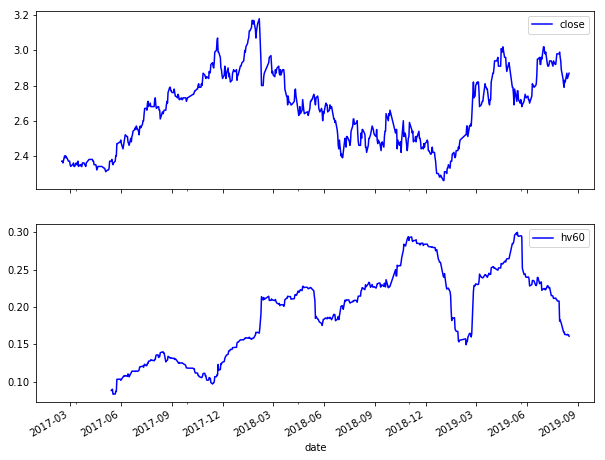

In [3]:
# 计算20190815的50etf的60日年化历史波动率

import tushare as ts

sz50 = ts.get_hist_data('510050',end='20190815') # 这个函数只能获取最近三年的数据
sz50.index = pd.DatetimeIndex(sz50.index) 
sz50 = sz50.sort_index(ascending = True)
sz50['log_ret']=np.log(sz50['close']/sz50['close'].shift(1))
sz50['hv60']=sz50['log_ret'].rolling(window=60,center=False).std() * np.sqrt(250)

print 'date:%s hv60:%s' %(sz50.index[-1],sz50['hv60'][-1])

sz50[['close','hv60']].plot(subplots=True,color='blue',figsize=(10,8))

In [4]:
# 配置日期计算条款
calendar = ql.China(ql.China.SSE)
dayCounter = ql.Actual365Fixed(ql.Actual365Fixed.Standard)

todayDate = ql.Date(15, ql.August, 2019)
maturity = ql.Date(28, ql.August, 2019)
settlementDate = todayDate

# 配置期权参数
etf = 2.858 # 50etf在20190815的收盘价
strike = 2.85 
riskFreeRate = 0.0259 # 无风险利率，取一年期国债到期收益率（中债），指标 ID S0059744
volatility = sz50['hv60'][-1] # 50etf的60日历史波动率
print volatility

# 配置全局估值日期
ql.Settings.instance().evaluationDate = todayDate

0.16082154675108154


In [5]:
# 配置行权条款
europeanExercise = ql.EuropeanExercise(maturity)
optionType = ql.Option.Call
payoff = ql.PlainVanillaPayoff(type=optionType, strike=strike)

# 构建期权对象
europeanOption = ql.VanillaOption(payoff=payoff,exercise=europeanExercise)

In [6]:
underlying = ql.SimpleQuote(etf)
underlyingH = ql.QuoteHandle(underlying)

# dividendYield = ql.YieldTermStructureHandle(ql.FlatForward(settlementDate,0,ql.Actual365Fixed())) 不考虑股息率

# 无风险利率的期限结构
flatRiskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(settlementDate, riskFreeRate, dayCounter))

# 波动率的期限结构
flatVolTS = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(settlementDate,calendar,volatility, dayCounter))

# 构建 BS 过程
bsProcess = ql.BlackScholesProcess(s0=underlyingH,riskFreeTS=flatRiskFreeTS,volTS=flatVolTS)

# 基于 BS 过程的公式定价引擎
pricingEngine = ql.AnalyticEuropeanEngine(bsProcess)

europeanOption.setPricingEngine(pricingEngine)

In [7]:
print("Option value =", europeanOption.NPV())
print("Delta value  =", europeanOption.delta())
print("Theta value  =", europeanOption.theta())
print("Theta perday =", europeanOption.thetaPerDay())
print("Gamma value  =", europeanOption.gamma())
print("Vega value   =", europeanOption.vega())
print("Rho value    =", europeanOption.rho())

('Option value =', 0.04011333873648456)
('Delta value  =', 0.5548502504875936)
('Theta value  =', -0.5212376123368616)
('Theta perday =', -0.0014280482529777031)
('Gamma value  =', 4.555619987421568)
('Vega value   =', 0.21314083421587537)
('Rho value    =', 0.05505050083025142)


# 第二种方法，按照万德计算公式自行计算后，和wind比对

In [8]:
from math import log,sqrt,exp,pi
from scipy import stats

In [9]:
def bsm_option_value(OptionType, s0, k, t, r, sigma):
    """
    OptionType：call,put
    s0：标的价格
    k：期权行权价
    t：采用自然日计算理论价、设距期权到期的自然日天数为Days，t=Days/365，Days=到期日-今日+1
    r：无风险利率，取一年期国债到期收益率（中债），指标 ID S0059744
    q：股息率，沪深交易所期权因分红后会调整行权价，股息率设为 0 ；期货期权，股息率等于无风险利率，即 q=r
    sigma：波动率，沪深交易所股票、ETF、指数期权，取标的 60 日波动率；期货期权，取标的主力连续合约 60 日波动率（比如 CU.SHF ）；
           年化天数均为250
       
    """
    d1 = ( log( s0/k ) + ( r + 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    d2 = ( log( s0/k ) + ( r - 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    if OptionType == 'call':
        value = ( s0*stats.norm.cdf(d1, 0.0, 1.0) - k*exp( -r*t )*stats.norm.cdf(d2, 0.0, 1.0))
    elif OptionType == 'put':
        value = ( -s0*stats.norm.cdf(-d1, 0.0, 1.0) + k*exp( -r*t )*stats.norm.cdf(-d2, 0.0, 1.0))
    else:
        value = 0
        print('OptionType input Error')
    return value

def bsm_delta(OptionType, s0, k, t, r, sigma):
    d1 = ( log( s0/k ) + ( r + 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    if OptionType == 'call':
        delta = stats.norm.cdf(d1, 0.0, 1.0)
    elif OptionType == 'put':
        delta = stats.norm.cdf(d1, 0.0, 1.0) - 1
    else:
        delta = 0
    return delta

def bsm_gamma(s0, k, t, r, sigma):
    d1 = ( log( s0/k ) + ( r + 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    gamma = stats.norm.pdf(d1) / (s0 * sigma * sqrt(t))
    return gamma

def bsm_vega(s0, k, t, r, sigma):
    d1 = log( s0/k ) + ( r + 0.5*sigma**2 )*t/( sigma*sqrt(t) )
    vega = s0 * stats.norm.pdf(d1) * sqrt(t) * 0.01
    return vega

def bsm_theta(OptionType, s0, k, t, r, sigma):
    d1 = ( log( s0/k ) + ( r + 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    d2 = ( log( s0/k ) + ( r - 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    if OptionType == 'call':
        theta = (-0.5 * s0 * stats.norm.pdf(d1) * sigma / sqrt(t) - r * k * exp(-r*t) * stats.norm.cdf(d2))/ 365
    elif OptionType == 'put':
        theta = (-0.5 * s0 * stats.norm.pdf(d1) * sigma / sqrt(t) + r * k * exp(-r*t) * stats.norm.cdf(-d2))/ 365
    else:
        theta = 0
    return theta

def bsm_rho(OptionType, s0, k, t, r, sigma):
    d2 = ( log( s0/k ) + ( r - 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    if OptionType == 'call':
        rho = t * k * exp(-r*t) * stats.norm.cdf(d2) * 0.01
    elif OptionType == 'put':
        rho = -t * k * exp(-r*t) * stats.norm.cdf(-d2) * 0.01
    else:
        rho = 0
    return rho

#牛顿迭代法求隐含波动率
def bsm_imp_vol_newton(OptionType, s0, k, t, r, c0, sigma_est):
    """
    c0: 期权价格
    """
    if ( OptionType == 'call' and c0 < s0 - k * exp(-r*t) ) or ( OptionType == 'call' and c0 < k * exp(-r*t) -s0 ):
        print(( OptionType == 'put' and c0 < s0 - k * exp(-r*t) ) or ( OptionType == 'put' and c0 < k * exp(-r*t) -s0 ))
        sigma_est = 0.0
    else:
        count = 0
        while True:
            if abs(bsm_option_value(OptionType, s0, k, t, r, sigma_est) - c0) <= 1e-5:
                break
            sigma_est = max(sigma_est - ((bsm_option_value(OptionType, s0, k, t, r, sigma_est) - c0)/ 
                          bsm_vega(s0, k, t, r, sigma_est)), 0.0001)
            #print(sigma_est)
            count += 1
            if count >= 500:
                sigma_est = 0.0
                break
                
    return sigma_est

In [10]:
# 准备期权参数，50ETF购8月2.85，wind代码10001886，在20190815收盘后
import datetime as dt
from __future__ import division

evaluationDate = dt.date(2019,8,15)
maturityDate = dt.date(2019,8,28)
dayCounter = (maturityDate - evaluationDate).days + 1

OptionType = 'call'
s0 = 2.858
k = 2.85
t = dayCounter/365 #采用自然日计算理论价、设距期权到期的自然日天数为Days，t=Days/365，Days=到期日-今日+1
r = 0.0259
q = 0
sigma = sz50['hv60'][-1]
print 'sigma: %s \n t: %s' %(sigma, t)

sigma: 0.16082154675108154 
 t: 0.0383561643836


In [11]:
print "option value: %s" % bsm_option_value(OptionType, s0, k, t, r, sigma)
print "delta: %s" % bsm_delta(OptionType, s0, k, t, r, sigma)
print "gamma: %s" % bsm_gamma(s0, k, t, r, sigma)
print "vega: %s" % bsm_vega(s0, k, t, r, sigma)
print "theta: %s" % bsm_theta(OptionType, s0, k, t, r, sigma)
print "rho: %s" % bsm_rho(OptionType, s0, k, t, r, sigma)

option value: 0.04151699589118496
delta: 0.5542023575369865
gamma: 4.390892074905643
vega: 0.0022302061288876256
theta: -0.0013801459296467718
rho: 0.000591602925679269
